In [1]:
# REPRODUCIBILATY
from numpy.random import seed
seed(12)
from tensorflow import set_random_seed
set_random_seed(12)

# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate as conc
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, precision_recall_fscore_support
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Nadam
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional
from keras.utils import plot_model
from keras import backend as K
from empyrical import max_drawdown
import os
import time
from datetime import timedelta
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


Using TensorFlow backend.
C:\Users\ikdem\AppData\Local\Programs\Python\Python35\lib\site-packages\empyrical\utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


In [2]:
def percentage_change(inp):
    arr =  ((np.diff(inp) / inp[:-1]))
    return arr

def binary(inp):
    l = []
    for i in range(len(inp)):
        if i == 0:
            continue
        else:
            if (inp[i] - inp[i-1]) > 0:
                l.append(1)
            else:
                l.append(0)
    return np.array(l)

def strategy_profit(yhat, yt, plot = False):
    signal = np.array([1 if p == 1 else -1 for p in binary(yhat)]) # Creates a trading signal to buy if price rises, sell if price drops
    signal = np.hstack((0,signal))
    
    df = pd.DataFrame() # Create dataframe for easier computation
    
    returns = yt.reshape((yt.shape[0], )) # create returns series from original data 
    returns[0] = 0
    
    df["return_strat"] = (returns * signal) # daily returns strategy
    np_return_strat = df["return_strat"].values # numpy array of daily returns
    
    df["cumulative_return_strat"] = ((1 + df['return_strat']).cumprod()) # cumulative return of strategy when reinvesting entire portfolio value
    df["return"] = returns 
    df["cumulative_return"] = ((1 + df['return']).cumprod()) # Returns of the buy and hold strategy (buy at t=0 and hold untill t=end)
    df["signal"] = signal


    if plot:
        plt.plot(df["cumulative_return"], "r", label = "Buy and hold")
        plt.plot(df["cumulative_return_strat"], "g", label = "Strategy")
        plt.plot()
        plt.legend()
        plt.show()
    return float(df.iloc[-1:]["cumulative_return_strat"] - df.iloc[-1:]["cumulative_return"]), \
            (math.sqrt(365.25) * np.mean(np_return_strat) / np.std(np_return_strat)), \
              max_drawdown(df["return_strat"])

In [3]:
# 920 - 1009
# prediction period vdataset["EtherPrice"].iloc[-1023:-934]

In [4]:
# IMPORTING DATASET
dataset = pd.read_csv('ethereum_trainval_dataset.csv')
dataset = dataset.sort_values(by=["UnixTimeStamp"])
dataset = dataset.reindex(index = dataset.index[::-1])
tdataset = pd.read_csv('ethereum_test_dataset.csv')
tdataset = tdataset.sort_values(by=["UnixTimeStamp"])
tdataset = tdataset.reindex(index = tdataset.index[::-1])

In [5]:
# deleting unwanted columns
del dataset["eth_supply"]
del dataset["eth_ethersupply"]
del dataset["eth_marketcap"]
del dataset["Unnamed: 0"]
del dataset["UnixTimeStamp"]
del dataset["eth_ens_register"]
del tdataset["Date(UTC)"]
del tdataset["UnixTimeStamp"]
del tdataset["Unnamed: 0"]

In [6]:
# Make price column the last one for easier use later on
cols = list(dataset)
cols[0], cols[11] = cols[11], cols[0]
dataset = dataset.ix[:,cols]
dataset = dataset[::-1]
tdataset = tdataset[::-1]

C:\Users\ikdem\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [7]:
# Accounting for blocktime being halved at index 809
dataset["eth_blocktime"].loc[809:] = dataset[809:]["eth_blocktime"] * 2
dataset["eth_uncles"].loc[809:] = dataset[809:]["eth_uncles"] / 2
dataset["eth_blocks"].loc[809:] = dataset[809:]["eth_blocks"] / 2
dataset["eth_difficulty"].loc[809:] = dataset[809:]["eth_difficulty"] * 2

dataset["eth_gasprice"][497] = dataset["eth_gasprice"][497] / 41



In [8]:
tdataset = tdataset[["GasUsed", "TxGrowth", "AddressCount", "NetworkHash", "BlockDifficulty", "BlockCountRewards", \
                     "Uncles", "BlockSize", "BlockTime", "AvgGasPrice", "GasLimit", "EtherPrice"]]

In [9]:
dataset = dataset[13:]
tdataset = tdataset[13:]

In [10]:
# Convert to numpy array and normalize data.
dataset = dataset.values.astype("float32")
tdataset = tdataset.values.astype("float32")

In [11]:
dataset_y = percentage_change(dataset[:, -1])
tdataset_y = percentage_change(tdataset[:, -1])

scaler_z = StandardScaler()

dataset_X = scaler_z.fit_transform(dataset[:, :-1])
tdataset_X = scaler_z.transform(tdataset[:, :-1])

tdataset_X = tdataset_X[0:-1,: ]
dataset_X = dataset_X[0:-1,: ]

tdataset_X = tdataset_X[921:1011]
yt = tdataset_y[921:1011]

print(tdataset_X.shape)
print(yt.shape)

(90, 11)
(90,)


In [12]:
## Train/test split
split = int(len(dataset)*0.9)

train_X = dataset_X[:split, :]
val_X = dataset_X[split:, :]

train_y = dataset_y[:split]
test_y = dataset_y[split:]

yv = test_y

# Reshape for LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = tdataset_X.reshape((tdataset_X.shape[0], 1, tdataset_X.shape[1]))



print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(test_y.shape)

(828, 1, 11)
(828,)
(92, 1, 11)
(92,)


In [13]:
# MODEL 1 (uncomment below to test this model)

# rms = RMSprop(lr = 0.0005)

# model = Sequential()

# model.add((LSTM(256, input_shape=(1, 11)))) 
# model.add(Dense(1))

# model.add(Activation('linear'))

# # Compile and Run
# model.compile(loss = "mean_squared_error", optimizer = rms) # Try SGD, adam, adagrad and compare!!!
# model.fit(train_X, train_y, epochs = 10000, batch_size = 128, verbose=2)

In [14]:
# MODEL 2 (uncomment below to test this model)
# rms = RMSprop(lr = 0.0005)

# model = Sequential()

# model.add((LSTM(64, input_shape=(1, 11), return_sequences = True))) 
# model.add((LSTM(64, input_shape=(1, 11))))

# model.add(Dense(1))
# model.add(Activation('linear'))

# # Compile and Run
# model.compile(loss = "mean_squared_error", optimizer = rms) # Try SGD, adam, adagrad and compare!!!
# model.fit(train_X, train_y, epochs = 2500, batch_size = 64, verbose=2)

In [15]:
# MODEL 3 (uncomment to test this model)
rms = RMSprop(lr = 0.0005)

model = Sequential()

model.add((LSTM(64, input_shape=(1, 11), return_sequences = True))) 
model.add(Activation("relu"))

model.add((LSTM(128, input_shape=(1, 11), return_sequences = True)))
model.add(Activation("relu"))

model.add((LSTM(128, input_shape=(1, 11))))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(32))
model.add(Dense(1))

model.add(Activation('linear'))

# Compile and Run
model.compile(loss = "mean_squared_error", optimizer = rms) # Try SGD, adam, adagrad and compare!!!
model.fit(train_X, train_y, epochs = 7500, batch_size = 128, verbose=2)

Epoch 1/7500
 - 2s - loss: 0.0064
Epoch 2/7500
 - 0s - loss: 0.0064
Epoch 3/7500
 - 0s - loss: 0.0064
Epoch 4/7500
 - 0s - loss: 0.0064
Epoch 5/7500
 - 0s - loss: 0.0064
Epoch 6/7500
 - 0s - loss: 0.0064
Epoch 7/7500
 - 0s - loss: 0.0064
Epoch 8/7500
 - 0s - loss: 0.0064
Epoch 9/7500
 - 0s - loss: 0.0064
Epoch 10/7500
 - 0s - loss: 0.0063
Epoch 11/7500
 - 0s - loss: 0.0064
Epoch 12/7500
 - 0s - loss: 0.0063
Epoch 13/7500
 - 0s - loss: 0.0064
Epoch 14/7500
 - 0s - loss: 0.0063
Epoch 15/7500
 - 0s - loss: 0.0064
Epoch 16/7500
 - 0s - loss: 0.0063
Epoch 17/7500
 - 0s - loss: 0.0063
Epoch 18/7500
 - 0s - loss: 0.0063
Epoch 19/7500
 - 0s - loss: 0.0063
Epoch 20/7500
 - 0s - loss: 0.0063
Epoch 21/7500
 - 0s - loss: 0.0063
Epoch 22/7500
 - 0s - loss: 0.0063
Epoch 23/7500
 - 0s - loss: 0.0063
Epoch 24/7500
 - 0s - loss: 0.0062
Epoch 25/7500
 - 0s - loss: 0.0063
Epoch 26/7500
 - 0s - loss: 0.0063
Epoch 27/7500
 - 0s - loss: 0.0063
Epoch 28/7500
 - 0s - loss: 0.0062
Epoch 29/7500
 - 0s - loss: 0

Epoch 232/7500
 - 0s - loss: 0.0054
Epoch 233/7500
 - 0s - loss: 0.0056
Epoch 234/7500
 - 0s - loss: 0.0054
Epoch 235/7500
 - 0s - loss: 0.0053
Epoch 236/7500
 - 0s - loss: 0.0053
Epoch 237/7500
 - 0s - loss: 0.0054
Epoch 238/7500
 - 0s - loss: 0.0053
Epoch 239/7500
 - 0s - loss: 0.0056
Epoch 240/7500
 - 0s - loss: 0.0054
Epoch 241/7500
 - 0s - loss: 0.0055
Epoch 242/7500
 - 0s - loss: 0.0053
Epoch 243/7500
 - 0s - loss: 0.0054
Epoch 244/7500
 - 0s - loss: 0.0053
Epoch 245/7500
 - 0s - loss: 0.0053
Epoch 246/7500
 - 0s - loss: 0.0053
Epoch 247/7500
 - 0s - loss: 0.0054
Epoch 248/7500
 - 0s - loss: 0.0053
Epoch 249/7500
 - 0s - loss: 0.0053
Epoch 250/7500
 - 0s - loss: 0.0052
Epoch 251/7500
 - 0s - loss: 0.0053
Epoch 252/7500
 - 0s - loss: 0.0054
Epoch 253/7500
 - 0s - loss: 0.0053
Epoch 254/7500
 - 0s - loss: 0.0054
Epoch 255/7500
 - 0s - loss: 0.0054
Epoch 256/7500
 - 0s - loss: 0.0053
Epoch 257/7500
 - 0s - loss: 0.0054
Epoch 258/7500
 - 0s - loss: 0.0053
Epoch 259/7500
 - 0s - loss:

Epoch 460/7500
 - 0s - loss: 0.0047
Epoch 461/7500
 - 0s - loss: 0.0046
Epoch 462/7500
 - 0s - loss: 0.0049
Epoch 463/7500
 - 0s - loss: 0.0048
Epoch 464/7500
 - 0s - loss: 0.0047
Epoch 465/7500
 - 0s - loss: 0.0049
Epoch 466/7500
 - 0s - loss: 0.0046
Epoch 467/7500
 - 0s - loss: 0.0049
Epoch 468/7500
 - 0s - loss: 0.0046
Epoch 469/7500
 - 0s - loss: 0.0048
Epoch 470/7500
 - 0s - loss: 0.0047
Epoch 471/7500
 - 0s - loss: 0.0047
Epoch 472/7500
 - 0s - loss: 0.0049
Epoch 473/7500
 - 0s - loss: 0.0047
Epoch 474/7500
 - 0s - loss: 0.0048
Epoch 475/7500
 - 0s - loss: 0.0045
Epoch 476/7500
 - 0s - loss: 0.0048
Epoch 477/7500
 - 0s - loss: 0.0047
Epoch 478/7500
 - 0s - loss: 0.0046
Epoch 479/7500
 - 0s - loss: 0.0046
Epoch 480/7500
 - 0s - loss: 0.0046
Epoch 481/7500
 - 0s - loss: 0.0050
Epoch 482/7500
 - 0s - loss: 0.0048
Epoch 483/7500
 - 0s - loss: 0.0045
Epoch 484/7500
 - 0s - loss: 0.0049
Epoch 485/7500
 - 0s - loss: 0.0047
Epoch 486/7500
 - 0s - loss: 0.0046
Epoch 487/7500
 - 0s - loss:

Epoch 688/7500
 - 0s - loss: 0.0044
Epoch 689/7500
 - 0s - loss: 0.0041
Epoch 690/7500
 - 0s - loss: 0.0042
Epoch 691/7500
 - 0s - loss: 0.0043
Epoch 692/7500
 - 0s - loss: 0.0042
Epoch 693/7500
 - 0s - loss: 0.0044
Epoch 694/7500
 - 0s - loss: 0.0042
Epoch 695/7500
 - 0s - loss: 0.0043
Epoch 696/7500
 - 0s - loss: 0.0041
Epoch 697/7500
 - 0s - loss: 0.0041
Epoch 698/7500
 - 0s - loss: 0.0045
Epoch 699/7500
 - 0s - loss: 0.0043
Epoch 700/7500
 - 0s - loss: 0.0042
Epoch 701/7500
 - 0s - loss: 0.0041
Epoch 702/7500
 - 0s - loss: 0.0044
Epoch 703/7500
 - 0s - loss: 0.0041
Epoch 704/7500
 - 0s - loss: 0.0043
Epoch 705/7500
 - 0s - loss: 0.0044
Epoch 706/7500
 - 0s - loss: 0.0042
Epoch 707/7500
 - 0s - loss: 0.0041
Epoch 708/7500
 - 0s - loss: 0.0042
Epoch 709/7500
 - 0s - loss: 0.0041
Epoch 710/7500
 - 0s - loss: 0.0045
Epoch 711/7500
 - 0s - loss: 0.0041
Epoch 712/7500
 - 0s - loss: 0.0042
Epoch 713/7500
 - 0s - loss: 0.0042
Epoch 714/7500
 - 0s - loss: 0.0041
Epoch 715/7500
 - 0s - loss:

Epoch 916/7500
 - 0s - loss: 0.0039
Epoch 917/7500
 - 0s - loss: 0.0037
Epoch 918/7500
 - 0s - loss: 0.0040
Epoch 919/7500
 - 0s - loss: 0.0039
Epoch 920/7500
 - 0s - loss: 0.0038
Epoch 921/7500
 - 0s - loss: 0.0038
Epoch 922/7500
 - 0s - loss: 0.0038
Epoch 923/7500
 - 0s - loss: 0.0044
Epoch 924/7500
 - 0s - loss: 0.0036
Epoch 925/7500
 - 0s - loss: 0.0040
Epoch 926/7500
 - 0s - loss: 0.0038
Epoch 927/7500
 - 0s - loss: 0.0038
Epoch 928/7500
 - 0s - loss: 0.0039
Epoch 929/7500
 - 0s - loss: 0.0039
Epoch 930/7500
 - 0s - loss: 0.0037
Epoch 931/7500
 - 0s - loss: 0.0039
Epoch 932/7500
 - 0s - loss: 0.0042
Epoch 933/7500
 - 0s - loss: 0.0037
Epoch 934/7500
 - 0s - loss: 0.0039
Epoch 935/7500
 - 0s - loss: 0.0038
Epoch 936/7500
 - 0s - loss: 0.0041
Epoch 937/7500
 - 0s - loss: 0.0038
Epoch 938/7500
 - 0s - loss: 0.0039
Epoch 939/7500
 - 0s - loss: 0.0039
Epoch 940/7500
 - 0s - loss: 0.0038
Epoch 941/7500
 - 0s - loss: 0.0037
Epoch 942/7500
 - 0s - loss: 0.0040
Epoch 943/7500
 - 0s - loss:

Epoch 1140/7500
 - 0s - loss: 0.0034
Epoch 1141/7500
 - 0s - loss: 0.0035
Epoch 1142/7500
 - 0s - loss: 0.0037
Epoch 1143/7500
 - 0s - loss: 0.0035
Epoch 1144/7500
 - 0s - loss: 0.0037
Epoch 1145/7500
 - 0s - loss: 0.0036
Epoch 1146/7500
 - 0s - loss: 0.0035
Epoch 1147/7500
 - 0s - loss: 0.0038
Epoch 1148/7500
 - 0s - loss: 0.0034
Epoch 1149/7500
 - 0s - loss: 0.0036
Epoch 1150/7500
 - 0s - loss: 0.0037
Epoch 1151/7500
 - 0s - loss: 0.0036
Epoch 1152/7500
 - 0s - loss: 0.0035
Epoch 1153/7500
 - 0s - loss: 0.0036
Epoch 1154/7500
 - 0s - loss: 0.0035
Epoch 1155/7500
 - 0s - loss: 0.0035
Epoch 1156/7500
 - 0s - loss: 0.0036
Epoch 1157/7500
 - 0s - loss: 0.0038
Epoch 1158/7500
 - 0s - loss: 0.0034
Epoch 1159/7500
 - 0s - loss: 0.0035
Epoch 1160/7500
 - 0s - loss: 0.0037
Epoch 1161/7500
 - 0s - loss: 0.0036
Epoch 1162/7500
 - 0s - loss: 0.0036
Epoch 1163/7500
 - 0s - loss: 0.0036
Epoch 1164/7500
 - 0s - loss: 0.0040
Epoch 1165/7500
 - 0s - loss: 0.0035
Epoch 1166/7500
 - 0s - loss: 0.0036
E

 - 0s - loss: 0.0035
Epoch 1362/7500
 - 0s - loss: 0.0032
Epoch 1363/7500
 - 0s - loss: 0.0032
Epoch 1364/7500
 - 0s - loss: 0.0034
Epoch 1365/7500
 - 0s - loss: 0.0034
Epoch 1366/7500
 - 0s - loss: 0.0032
Epoch 1367/7500
 - 0s - loss: 0.0033
Epoch 1368/7500
 - 0s - loss: 0.0032
Epoch 1369/7500
 - 0s - loss: 0.0034
Epoch 1370/7500
 - 0s - loss: 0.0032
Epoch 1371/7500
 - 0s - loss: 0.0037
Epoch 1372/7500
 - 0s - loss: 0.0032
Epoch 1373/7500
 - 0s - loss: 0.0035
Epoch 1374/7500
 - 0s - loss: 0.0032
Epoch 1375/7500
 - 0s - loss: 0.0036
Epoch 1376/7500
 - 0s - loss: 0.0033
Epoch 1377/7500
 - 0s - loss: 0.0033
Epoch 1378/7500
 - 0s - loss: 0.0035
Epoch 1379/7500
 - 0s - loss: 0.0034
Epoch 1380/7500
 - 0s - loss: 0.0032
Epoch 1381/7500
 - 0s - loss: 0.0033
Epoch 1382/7500
 - 0s - loss: 0.0035
Epoch 1383/7500
 - 0s - loss: 0.0031
Epoch 1384/7500
 - 0s - loss: 0.0033
Epoch 1385/7500
 - 0s - loss: 0.0036
Epoch 1386/7500
 - 0s - loss: 0.0031
Epoch 1387/7500
 - 0s - loss: 0.0033
Epoch 1388/7500
 

Epoch 1583/7500
 - 0s - loss: 0.0029
Epoch 1584/7500
 - 0s - loss: 0.0031
Epoch 1585/7500
 - 0s - loss: 0.0031
Epoch 1586/7500
 - 0s - loss: 0.0030
Epoch 1587/7500
 - 0s - loss: 0.0030
Epoch 1588/7500
 - 0s - loss: 0.0030
Epoch 1589/7500
 - 0s - loss: 0.0028
Epoch 1590/7500
 - 0s - loss: 0.0033
Epoch 1591/7500
 - 0s - loss: 0.0032
Epoch 1592/7500
 - 0s - loss: 0.0030
Epoch 1593/7500
 - 0s - loss: 0.0029
Epoch 1594/7500
 - 0s - loss: 0.0031
Epoch 1595/7500
 - 0s - loss: 0.0029
Epoch 1596/7500
 - 0s - loss: 0.0032
Epoch 1597/7500
 - 0s - loss: 0.0031
Epoch 1598/7500
 - 0s - loss: 0.0030
Epoch 1599/7500
 - 0s - loss: 0.0031
Epoch 1600/7500
 - 0s - loss: 0.0028
Epoch 1601/7500
 - 0s - loss: 0.0030
Epoch 1602/7500
 - 0s - loss: 0.0030
Epoch 1603/7500
 - 0s - loss: 0.0031
Epoch 1604/7500
 - 0s - loss: 0.0035
Epoch 1605/7500
 - 0s - loss: 0.0030
Epoch 1606/7500
 - 0s - loss: 0.0032
Epoch 1607/7500
 - 0s - loss: 0.0029
Epoch 1608/7500
 - 0s - loss: 0.0032
Epoch 1609/7500
 - 0s - loss: 0.0030
E

Epoch 1805/7500
 - 0s - loss: 0.0029
Epoch 1806/7500
 - 0s - loss: 0.0028
Epoch 1807/7500
 - 0s - loss: 0.0026
Epoch 1808/7500
 - 0s - loss: 0.0030
Epoch 1809/7500
 - 0s - loss: 0.0024
Epoch 1810/7500
 - 0s - loss: 0.0025
Epoch 1811/7500
 - 0s - loss: 0.0030
Epoch 1812/7500
 - 0s - loss: 0.0028
Epoch 1813/7500
 - 0s - loss: 0.0026
Epoch 1814/7500
 - 0s - loss: 0.0026
Epoch 1815/7500
 - 0s - loss: 0.0029
Epoch 1816/7500
 - 0s - loss: 0.0028
Epoch 1817/7500
 - 0s - loss: 0.0025
Epoch 1818/7500
 - 0s - loss: 0.0025
Epoch 1819/7500
 - 0s - loss: 0.0029
Epoch 1820/7500
 - 0s - loss: 0.0025
Epoch 1821/7500
 - 0s - loss: 0.0027
Epoch 1822/7500
 - 0s - loss: 0.0028
Epoch 1823/7500
 - 0s - loss: 0.0027
Epoch 1824/7500
 - 0s - loss: 0.0025
Epoch 1825/7500
 - 0s - loss: 0.0029
Epoch 1826/7500
 - 0s - loss: 0.0026
Epoch 1827/7500
 - 0s - loss: 0.0026
Epoch 1828/7500
 - 0s - loss: 0.0027
Epoch 1829/7500
 - 0s - loss: 0.0029
Epoch 1830/7500
 - 0s - loss: 0.0024
Epoch 1831/7500
 - 0s - loss: 0.0029
E

 - 0s - loss: 0.0022
Epoch 2027/7500
 - 0s - loss: 0.0023
Epoch 2028/7500
 - 0s - loss: 0.0025
Epoch 2029/7500
 - 0s - loss: 0.0025
Epoch 2030/7500
 - 0s - loss: 0.0024
Epoch 2031/7500
 - 0s - loss: 0.0021
Epoch 2032/7500
 - 0s - loss: 0.0027
Epoch 2033/7500
 - 0s - loss: 0.0024
Epoch 2034/7500
 - 0s - loss: 0.0027
Epoch 2035/7500
 - 0s - loss: 0.0022
Epoch 2036/7500
 - 0s - loss: 0.0025
Epoch 2037/7500
 - 0s - loss: 0.0023
Epoch 2038/7500
 - 0s - loss: 0.0025
Epoch 2039/7500
 - 0s - loss: 0.0022
Epoch 2040/7500
 - 0s - loss: 0.0022
Epoch 2041/7500
 - 0s - loss: 0.0024
Epoch 2042/7500
 - 0s - loss: 0.0023
Epoch 2043/7500
 - 0s - loss: 0.0024
Epoch 2044/7500
 - 0s - loss: 0.0025
Epoch 2045/7500
 - 0s - loss: 0.0025
Epoch 2046/7500
 - 0s - loss: 0.0021
Epoch 2047/7500
 - 0s - loss: 0.0023
Epoch 2048/7500
 - 0s - loss: 0.0026
Epoch 2049/7500
 - 0s - loss: 0.0023
Epoch 2050/7500
 - 0s - loss: 0.0024
Epoch 2051/7500
 - 0s - loss: 0.0022
Epoch 2052/7500
 - 0s - loss: 0.0027
Epoch 2053/7500
 

Epoch 2248/7500
 - 0s - loss: 0.0021
Epoch 2249/7500
 - 0s - loss: 0.0022
Epoch 2250/7500
 - 0s - loss: 0.0019
Epoch 2251/7500
 - 0s - loss: 0.0023
Epoch 2252/7500
 - 0s - loss: 0.0020
Epoch 2253/7500
 - 0s - loss: 0.0022
Epoch 2254/7500
 - 0s - loss: 0.0022
Epoch 2255/7500
 - 0s - loss: 0.0019
Epoch 2256/7500
 - 0s - loss: 0.0025
Epoch 2257/7500
 - 0s - loss: 0.0023
Epoch 2258/7500
 - 0s - loss: 0.0018
Epoch 2259/7500
 - 0s - loss: 0.0021
Epoch 2260/7500
 - 0s - loss: 0.0024
Epoch 2261/7500
 - 0s - loss: 0.0021
Epoch 2262/7500
 - 0s - loss: 0.0021
Epoch 2263/7500
 - 0s - loss: 0.0020
Epoch 2264/7500
 - 0s - loss: 0.0021
Epoch 2265/7500
 - 0s - loss: 0.0024
Epoch 2266/7500
 - 0s - loss: 0.0020
Epoch 2267/7500
 - 0s - loss: 0.0020
Epoch 2268/7500
 - 0s - loss: 0.0025
Epoch 2269/7500
 - 0s - loss: 0.0019
Epoch 2270/7500
 - 0s - loss: 0.0022
Epoch 2271/7500
 - 0s - loss: 0.0024
Epoch 2272/7500
 - 0s - loss: 0.0019
Epoch 2273/7500
 - 0s - loss: 0.0023
Epoch 2274/7500
 - 0s - loss: 0.0021
E

 - 0s - loss: 0.0018
Epoch 2470/7500
 - 0s - loss: 0.0020
Epoch 2471/7500
 - 0s - loss: 0.0018
Epoch 2472/7500
 - 0s - loss: 0.0019
Epoch 2473/7500
 - 0s - loss: 0.0019
Epoch 2474/7500
 - 0s - loss: 0.0023
Epoch 2475/7500
 - 0s - loss: 0.0019
Epoch 2476/7500
 - 0s - loss: 0.0017
Epoch 2477/7500
 - 0s - loss: 0.0021
Epoch 2478/7500
 - 0s - loss: 0.0020
Epoch 2479/7500
 - 0s - loss: 0.0023
Epoch 2480/7500
 - 0s - loss: 0.0019
Epoch 2481/7500
 - 0s - loss: 0.0022
Epoch 2482/7500
 - 0s - loss: 0.0018
Epoch 2483/7500
 - 0s - loss: 0.0019
Epoch 2484/7500
 - 0s - loss: 0.0019
Epoch 2485/7500
 - 0s - loss: 0.0019
Epoch 2486/7500
 - 0s - loss: 0.0021
Epoch 2487/7500
 - 0s - loss: 0.0020
Epoch 2488/7500
 - 0s - loss: 0.0017
Epoch 2489/7500
 - 0s - loss: 0.0018
Epoch 2490/7500
 - 0s - loss: 0.0023
Epoch 2491/7500
 - 0s - loss: 0.0020
Epoch 2492/7500
 - 0s - loss: 0.0018
Epoch 2493/7500
 - 0s - loss: 0.0018
Epoch 2494/7500
 - 0s - loss: 0.0018
Epoch 2495/7500
 - 0s - loss: 0.0019
Epoch 2496/7500
 

Epoch 2691/7500
 - 0s - loss: 0.0016
Epoch 2692/7500
 - 0s - loss: 0.0020
Epoch 2693/7500
 - 0s - loss: 0.0018
Epoch 2694/7500
 - 0s - loss: 0.0018
Epoch 2695/7500
 - 0s - loss: 0.0020
Epoch 2696/7500
 - 0s - loss: 0.0015
Epoch 2697/7500
 - 0s - loss: 0.0019
Epoch 2698/7500
 - 0s - loss: 0.0019
Epoch 2699/7500
 - 0s - loss: 0.0018
Epoch 2700/7500
 - 0s - loss: 0.0018
Epoch 2701/7500
 - 0s - loss: 0.0018
Epoch 2702/7500
 - 0s - loss: 0.0017
Epoch 2703/7500
 - 0s - loss: 0.0019
Epoch 2704/7500
 - 0s - loss: 0.0018
Epoch 2705/7500
 - 0s - loss: 0.0018
Epoch 2706/7500
 - 0s - loss: 0.0020
Epoch 2707/7500
 - 0s - loss: 0.0017
Epoch 2708/7500
 - 0s - loss: 0.0016
Epoch 2709/7500
 - 0s - loss: 0.0018
Epoch 2710/7500
 - 0s - loss: 0.0017
Epoch 2711/7500
 - 0s - loss: 0.0016
Epoch 2712/7500
 - 0s - loss: 0.0017
Epoch 2713/7500
 - 0s - loss: 0.0018
Epoch 2714/7500
 - 0s - loss: 0.0018
Epoch 2715/7500
 - 0s - loss: 0.0016
Epoch 2716/7500
 - 0s - loss: 0.0018
Epoch 2717/7500
 - 0s - loss: 0.0017
E

 - 0s - loss: 0.0019
Epoch 2913/7500
 - 0s - loss: 0.0015
Epoch 2914/7500
 - 0s - loss: 0.0014
Epoch 2915/7500
 - 0s - loss: 0.0017
Epoch 2916/7500
 - 0s - loss: 0.0016
Epoch 2917/7500
 - 0s - loss: 0.0014
Epoch 2918/7500
 - 0s - loss: 0.0016
Epoch 2919/7500
 - 0s - loss: 0.0018
Epoch 2920/7500
 - 0s - loss: 0.0016
Epoch 2921/7500
 - 0s - loss: 0.0016
Epoch 2922/7500
 - 0s - loss: 0.0016
Epoch 2923/7500
 - 0s - loss: 0.0018
Epoch 2924/7500
 - 0s - loss: 0.0015
Epoch 2925/7500
 - 0s - loss: 0.0014
Epoch 2926/7500
 - 0s - loss: 0.0018
Epoch 2927/7500
 - 0s - loss: 0.0017
Epoch 2928/7500
 - 0s - loss: 0.0017
Epoch 2929/7500
 - 0s - loss: 0.0016
Epoch 2930/7500
 - 0s - loss: 0.0016
Epoch 2931/7500
 - 0s - loss: 0.0016
Epoch 2932/7500
 - 0s - loss: 0.0021
Epoch 2933/7500
 - 0s - loss: 0.0014
Epoch 2934/7500
 - 0s - loss: 0.0017
Epoch 2935/7500
 - 0s - loss: 0.0018
Epoch 2936/7500
 - 0s - loss: 0.0015
Epoch 2937/7500
 - 0s - loss: 0.0014
Epoch 2938/7500
 - 0s - loss: 0.0017
Epoch 2939/7500
 

Epoch 3134/7500
 - 0s - loss: 0.0013
Epoch 3135/7500
 - 0s - loss: 0.0019
Epoch 3136/7500
 - 0s - loss: 0.0013
Epoch 3137/7500
 - 0s - loss: 0.0014
Epoch 3138/7500
 - 0s - loss: 0.0015
Epoch 3139/7500
 - 0s - loss: 0.0016
Epoch 3140/7500
 - 0s - loss: 0.0015
Epoch 3141/7500
 - 0s - loss: 0.0013
Epoch 3142/7500
 - 0s - loss: 0.0014
Epoch 3143/7500
 - 0s - loss: 0.0016
Epoch 3144/7500
 - 0s - loss: 0.0015
Epoch 3145/7500
 - 0s - loss: 0.0016
Epoch 3146/7500
 - 0s - loss: 0.0015
Epoch 3147/7500
 - 0s - loss: 0.0013
Epoch 3148/7500
 - 0s - loss: 0.0016
Epoch 3149/7500
 - 0s - loss: 0.0016
Epoch 3150/7500
 - 0s - loss: 0.0013
Epoch 3151/7500
 - 0s - loss: 0.0013
Epoch 3152/7500
 - 0s - loss: 0.0014
Epoch 3153/7500
 - 0s - loss: 0.0016
Epoch 3154/7500
 - 0s - loss: 0.0013
Epoch 3155/7500
 - 0s - loss: 0.0016
Epoch 3156/7500
 - 0s - loss: 0.0013
Epoch 3157/7500
 - 0s - loss: 0.0016
Epoch 3158/7500
 - 0s - loss: 0.0013
Epoch 3159/7500
 - 0s - loss: 0.0015
Epoch 3160/7500
 - 0s - loss: 0.0014
E

 - 0s - loss: 0.0012
Epoch 3356/7500
 - 0s - loss: 0.0013
Epoch 3357/7500
 - 0s - loss: 0.0016
Epoch 3358/7500
 - 0s - loss: 0.0011
Epoch 3359/7500
 - 0s - loss: 0.0012
Epoch 3360/7500
 - 0s - loss: 0.0015
Epoch 3361/7500
 - 0s - loss: 0.0014
Epoch 3362/7500
 - 0s - loss: 0.0011
Epoch 3363/7500
 - 0s - loss: 0.0012
Epoch 3364/7500
 - 0s - loss: 0.0014
Epoch 3365/7500
 - 0s - loss: 0.0014
Epoch 3366/7500
 - 0s - loss: 0.0013
Epoch 3367/7500
 - 0s - loss: 0.0015
Epoch 3368/7500
 - 0s - loss: 0.0012
Epoch 3369/7500
 - 0s - loss: 0.0012
Epoch 3370/7500
 - 0s - loss: 0.0014
Epoch 3371/7500
 - 0s - loss: 0.0013
Epoch 3372/7500
 - 0s - loss: 0.0014
Epoch 3373/7500
 - 0s - loss: 0.0013
Epoch 3374/7500
 - 0s - loss: 0.0013
Epoch 3375/7500
 - 0s - loss: 0.0013
Epoch 3376/7500
 - 0s - loss: 0.0012
Epoch 3377/7500
 - 0s - loss: 0.0017
Epoch 3378/7500
 - 0s - loss: 0.0013
Epoch 3379/7500
 - 0s - loss: 0.0013
Epoch 3380/7500
 - 0s - loss: 0.0016
Epoch 3381/7500
 - 0s - loss: 0.0012
Epoch 3382/7500
 

Epoch 3577/7500
 - 0s - loss: 0.0012
Epoch 3578/7500
 - 0s - loss: 0.0011
Epoch 3579/7500
 - 0s - loss: 0.0011
Epoch 3580/7500
 - 0s - loss: 0.0016
Epoch 3581/7500
 - 0s - loss: 0.0010
Epoch 3582/7500
 - 0s - loss: 0.0011
Epoch 3583/7500
 - 0s - loss: 0.0012
Epoch 3584/7500
 - 0s - loss: 0.0014
Epoch 3585/7500
 - 0s - loss: 0.0011
Epoch 3586/7500
 - 0s - loss: 0.0012
Epoch 3587/7500
 - 0s - loss: 0.0012
Epoch 3588/7500
 - 0s - loss: 0.0010
Epoch 3589/7500
 - 0s - loss: 0.0012
Epoch 3590/7500
 - 0s - loss: 0.0013
Epoch 3591/7500
 - 0s - loss: 0.0013
Epoch 3592/7500
 - 0s - loss: 0.0010
Epoch 3593/7500
 - 0s - loss: 0.0014
Epoch 3594/7500
 - 0s - loss: 0.0013
Epoch 3595/7500
 - 0s - loss: 0.0010
Epoch 3596/7500
 - 0s - loss: 0.0014
Epoch 3597/7500
 - 0s - loss: 0.0011
Epoch 3598/7500
 - 0s - loss: 0.0014
Epoch 3599/7500
 - 0s - loss: 9.7199e-04
Epoch 3600/7500
 - 0s - loss: 0.0013
Epoch 3601/7500
 - 0s - loss: 0.0012
Epoch 3602/7500
 - 0s - loss: 9.8113e-04
Epoch 3603/7500
 - 0s - loss: 

Epoch 3797/7500
 - 0s - loss: 0.0012
Epoch 3798/7500
 - 0s - loss: 0.0011
Epoch 3799/7500
 - 0s - loss: 9.0141e-04
Epoch 3800/7500
 - 0s - loss: 0.0011
Epoch 3801/7500
 - 0s - loss: 0.0012
Epoch 3802/7500
 - 0s - loss: 0.0010
Epoch 3803/7500
 - 0s - loss: 0.0010
Epoch 3804/7500
 - 0s - loss: 0.0011
Epoch 3805/7500
 - 0s - loss: 0.0011
Epoch 3806/7500
 - 0s - loss: 0.0014
Epoch 3807/7500
 - 0s - loss: 0.0012
Epoch 3808/7500
 - 0s - loss: 8.8025e-04
Epoch 3809/7500
 - 0s - loss: 0.0012
Epoch 3810/7500
 - 0s - loss: 9.6056e-04
Epoch 3811/7500
 - 0s - loss: 0.0011
Epoch 3812/7500
 - 0s - loss: 0.0011
Epoch 3813/7500
 - 0s - loss: 0.0011
Epoch 3814/7500
 - 0s - loss: 0.0012
Epoch 3815/7500
 - 0s - loss: 9.3437e-04
Epoch 3816/7500
 - 0s - loss: 0.0011
Epoch 3817/7500
 - 0s - loss: 0.0011
Epoch 3818/7500
 - 0s - loss: 0.0010
Epoch 3819/7500
 - 0s - loss: 0.0010
Epoch 3820/7500
 - 0s - loss: 9.5619e-04
Epoch 3821/7500
 - 0s - loss: 0.0012
Epoch 3822/7500
 - 0s - loss: 0.0012
Epoch 3823/7500
 -

 - 0s - loss: 9.4460e-04
Epoch 4010/7500
 - 0s - loss: 0.0011
Epoch 4011/7500
 - 0s - loss: 0.0011
Epoch 4012/7500
 - 0s - loss: 0.0010
Epoch 4013/7500
 - 0s - loss: 9.1230e-04
Epoch 4014/7500
 - 0s - loss: 9.7521e-04
Epoch 4015/7500
 - 0s - loss: 9.6586e-04
Epoch 4016/7500
 - 0s - loss: 9.0620e-04
Epoch 4017/7500
 - 0s - loss: 7.9639e-04
Epoch 4018/7500
 - 0s - loss: 0.0011
Epoch 4019/7500
 - 0s - loss: 9.5436e-04
Epoch 4020/7500
 - 0s - loss: 0.0012
Epoch 4021/7500
 - 0s - loss: 8.9939e-04
Epoch 4022/7500
 - 0s - loss: 9.5079e-04
Epoch 4023/7500
 - 0s - loss: 9.4544e-04
Epoch 4024/7500
 - 0s - loss: 8.3264e-04
Epoch 4025/7500
 - 0s - loss: 0.0011
Epoch 4026/7500
 - 0s - loss: 7.3206e-04
Epoch 4027/7500
 - 0s - loss: 0.0013
Epoch 4028/7500
 - 0s - loss: 9.3187e-04
Epoch 4029/7500
 - 0s - loss: 8.7482e-04
Epoch 4030/7500
 - 0s - loss: 0.0011
Epoch 4031/7500
 - 0s - loss: 0.0010
Epoch 4032/7500
 - 0s - loss: 0.0010
Epoch 4033/7500
 - 0s - loss: 8.3112e-04
Epoch 4034/7500
 - 0s - loss: 8

Epoch 4217/7500
 - 0s - loss: 7.5024e-04
Epoch 4218/7500
 - 0s - loss: 0.0013
Epoch 4219/7500
 - 0s - loss: 0.0010
Epoch 4220/7500
 - 0s - loss: 6.8689e-04
Epoch 4221/7500
 - 0s - loss: 7.6654e-04
Epoch 4222/7500
 - 0s - loss: 7.9423e-04
Epoch 4223/7500
 - 0s - loss: 9.0236e-04
Epoch 4224/7500
 - 0s - loss: 9.1833e-04
Epoch 4225/7500
 - 0s - loss: 0.0010
Epoch 4226/7500
 - 0s - loss: 8.1239e-04
Epoch 4227/7500
 - 0s - loss: 0.0010
Epoch 4228/7500
 - 0s - loss: 9.1106e-04
Epoch 4229/7500
 - 0s - loss: 0.0010
Epoch 4230/7500
 - 0s - loss: 9.0580e-04
Epoch 4231/7500
 - 0s - loss: 7.9143e-04
Epoch 4232/7500
 - 0s - loss: 7.9085e-04
Epoch 4233/7500
 - 0s - loss: 0.0011
Epoch 4234/7500
 - 0s - loss: 8.7710e-04
Epoch 4235/7500
 - 0s - loss: 7.8551e-04
Epoch 4236/7500
 - 0s - loss: 9.1053e-04
Epoch 4237/7500
 - 0s - loss: 8.4631e-04
Epoch 4238/7500
 - 0s - loss: 9.3252e-04
Epoch 4239/7500
 - 0s - loss: 8.1831e-04
Epoch 4240/7500
 - 0s - loss: 0.0013
Epoch 4241/7500
 - 0s - loss: 7.4396e-04
Epo

Epoch 4420/7500
 - 0s - loss: 8.3809e-04
Epoch 4421/7500
 - 0s - loss: 7.4084e-04
Epoch 4422/7500
 - 0s - loss: 8.2543e-04
Epoch 4423/7500
 - 0s - loss: 9.1998e-04
Epoch 4424/7500
 - 0s - loss: 6.8181e-04
Epoch 4425/7500
 - 0s - loss: 8.8828e-04
Epoch 4426/7500
 - 0s - loss: 9.5735e-04
Epoch 4427/7500
 - 0s - loss: 5.3877e-04
Epoch 4428/7500
 - 0s - loss: 7.3624e-04
Epoch 4429/7500
 - 0s - loss: 8.7128e-04
Epoch 4430/7500
 - 0s - loss: 8.9162e-04
Epoch 4431/7500
 - 0s - loss: 0.0011
Epoch 4432/7500
 - 0s - loss: 7.2663e-04
Epoch 4433/7500
 - 0s - loss: 8.3462e-04
Epoch 4434/7500
 - 0s - loss: 0.0010
Epoch 4435/7500
 - 0s - loss: 9.0722e-04
Epoch 4436/7500
 - 0s - loss: 6.2021e-04
Epoch 4437/7500
 - 0s - loss: 6.7885e-04
Epoch 4438/7500
 - 0s - loss: 9.7663e-04
Epoch 4439/7500
 - 0s - loss: 8.3686e-04
Epoch 4440/7500
 - 0s - loss: 8.5220e-04
Epoch 4441/7500
 - 0s - loss: 8.8914e-04
Epoch 4442/7500
 - 0s - loss: 9.4900e-04
Epoch 4443/7500
 - 0s - loss: 0.0011
Epoch 4444/7500
 - 0s - loss

Epoch 4622/7500
 - 0s - loss: 9.1557e-04
Epoch 4623/7500
 - 0s - loss: 6.6637e-04
Epoch 4624/7500
 - 0s - loss: 5.9230e-04
Epoch 4625/7500
 - 0s - loss: 8.0037e-04
Epoch 4626/7500
 - 0s - loss: 6.2557e-04
Epoch 4627/7500
 - 0s - loss: 6.9487e-04
Epoch 4628/7500
 - 0s - loss: 7.5198e-04
Epoch 4629/7500
 - 0s - loss: 8.9550e-04
Epoch 4630/7500
 - 0s - loss: 5.4593e-04
Epoch 4631/7500
 - 0s - loss: 6.7622e-04
Epoch 4632/7500
 - 0s - loss: 7.8881e-04
Epoch 4633/7500
 - 0s - loss: 6.1597e-04
Epoch 4634/7500
 - 0s - loss: 7.4053e-04
Epoch 4635/7500
 - 0s - loss: 6.8806e-04
Epoch 4636/7500
 - 0s - loss: 6.8023e-04
Epoch 4637/7500
 - 0s - loss: 8.3990e-04
Epoch 4638/7500
 - 0s - loss: 7.7435e-04
Epoch 4639/7500
 - 0s - loss: 7.7286e-04
Epoch 4640/7500
 - 0s - loss: 6.1010e-04
Epoch 4641/7500
 - 0s - loss: 7.7783e-04
Epoch 4642/7500
 - 0s - loss: 6.7114e-04
Epoch 4643/7500
 - 0s - loss: 7.3862e-04
Epoch 4644/7500
 - 0s - loss: 6.9449e-04
Epoch 4645/7500
 - 0s - loss: 0.0010
Epoch 4646/7500
 - 0

Epoch 4823/7500
 - 0s - loss: 8.9677e-04
Epoch 4824/7500
 - 0s - loss: 9.3503e-04
Epoch 4825/7500
 - 0s - loss: 6.0955e-04
Epoch 4826/7500
 - 0s - loss: 6.1638e-04
Epoch 4827/7500
 - 0s - loss: 6.1167e-04
Epoch 4828/7500
 - 0s - loss: 7.1517e-04
Epoch 4829/7500
 - 0s - loss: 6.3979e-04
Epoch 4830/7500
 - 0s - loss: 6.2188e-04
Epoch 4831/7500
 - 0s - loss: 7.8146e-04
Epoch 4832/7500
 - 0s - loss: 6.1369e-04
Epoch 4833/7500
 - 0s - loss: 8.5991e-04
Epoch 4834/7500
 - 0s - loss: 6.1149e-04
Epoch 4835/7500
 - 0s - loss: 6.4505e-04
Epoch 4836/7500
 - 0s - loss: 5.5251e-04
Epoch 4837/7500
 - 0s - loss: 8.1551e-04
Epoch 4838/7500
 - 0s - loss: 6.9743e-04
Epoch 4839/7500
 - 0s - loss: 6.4371e-04
Epoch 4840/7500
 - 0s - loss: 7.9292e-04
Epoch 4841/7500
 - 0s - loss: 5.6687e-04
Epoch 4842/7500
 - 0s - loss: 6.7173e-04
Epoch 4843/7500
 - 0s - loss: 7.8834e-04
Epoch 4844/7500
 - 0s - loss: 6.8834e-04
Epoch 4845/7500
 - 0s - loss: 5.7236e-04
Epoch 4846/7500
 - 0s - loss: 7.8270e-04
Epoch 4847/7500


 - 0s - loss: 7.4572e-04
Epoch 5024/7500
 - 0s - loss: 5.1768e-04
Epoch 5025/7500
 - 0s - loss: 5.4785e-04
Epoch 5026/7500
 - 0s - loss: 5.4159e-04
Epoch 5027/7500
 - 0s - loss: 7.8078e-04
Epoch 5028/7500
 - 0s - loss: 5.8724e-04
Epoch 5029/7500
 - 0s - loss: 6.7998e-04
Epoch 5030/7500
 - 0s - loss: 7.7089e-04
Epoch 5031/7500
 - 0s - loss: 5.6439e-04
Epoch 5032/7500
 - 0s - loss: 5.2486e-04
Epoch 5033/7500
 - 0s - loss: 5.9289e-04
Epoch 5034/7500
 - 0s - loss: 7.2811e-04
Epoch 5035/7500
 - 0s - loss: 6.5581e-04
Epoch 5036/7500
 - 0s - loss: 5.8616e-04
Epoch 5037/7500
 - 0s - loss: 7.5078e-04
Epoch 5038/7500
 - 0s - loss: 4.8438e-04
Epoch 5039/7500
 - 0s - loss: 7.8628e-04
Epoch 5040/7500
 - 0s - loss: 4.8856e-04
Epoch 5041/7500
 - 0s - loss: 7.2552e-04
Epoch 5042/7500
 - 0s - loss: 7.8244e-04
Epoch 5043/7500
 - 0s - loss: 5.9112e-04
Epoch 5044/7500
 - 0s - loss: 5.3055e-04
Epoch 5045/7500
 - 0s - loss: 5.1971e-04
Epoch 5046/7500
 - 0s - loss: 7.1477e-04
Epoch 5047/7500
 - 0s - loss: 6.

 - 0s - loss: 6.2572e-04
Epoch 5224/7500
 - 0s - loss: 4.7135e-04
Epoch 5225/7500
 - 0s - loss: 5.1376e-04
Epoch 5226/7500
 - 0s - loss: 8.4913e-04
Epoch 5227/7500
 - 0s - loss: 4.4568e-04
Epoch 5228/7500
 - 0s - loss: 5.0978e-04
Epoch 5229/7500
 - 0s - loss: 6.8611e-04
Epoch 5230/7500
 - 0s - loss: 6.5754e-04
Epoch 5231/7500
 - 0s - loss: 4.4116e-04
Epoch 5232/7500
 - 0s - loss: 5.8437e-04
Epoch 5233/7500
 - 0s - loss: 4.5095e-04
Epoch 5234/7500
 - 0s - loss: 7.0868e-04
Epoch 5235/7500
 - 0s - loss: 6.2679e-04
Epoch 5236/7500
 - 0s - loss: 5.0381e-04
Epoch 5237/7500
 - 0s - loss: 4.3169e-04
Epoch 5238/7500
 - 0s - loss: 5.3887e-04
Epoch 5239/7500
 - 0s - loss: 4.9875e-04
Epoch 5240/7500
 - 0s - loss: 5.8060e-04
Epoch 5241/7500
 - 0s - loss: 7.2472e-04
Epoch 5242/7500
 - 0s - loss: 6.4257e-04
Epoch 5243/7500
 - 0s - loss: 5.7424e-04
Epoch 5244/7500
 - 0s - loss: 5.2370e-04
Epoch 5245/7500
 - 0s - loss: 5.0598e-04
Epoch 5246/7500
 - 0s - loss: 6.3531e-04
Epoch 5247/7500
 - 0s - loss: 6.

Epoch 5424/7500
 - 0s - loss: 4.6787e-04
Epoch 5425/7500
 - 0s - loss: 4.8006e-04
Epoch 5426/7500
 - 0s - loss: 4.8130e-04
Epoch 5427/7500
 - 0s - loss: 6.6811e-04
Epoch 5428/7500
 - 0s - loss: 4.7621e-04
Epoch 5429/7500
 - 0s - loss: 3.8989e-04
Epoch 5430/7500
 - 0s - loss: 5.7954e-04
Epoch 5431/7500
 - 0s - loss: 7.0820e-04
Epoch 5432/7500
 - 0s - loss: 6.3779e-04
Epoch 5433/7500
 - 0s - loss: 4.5922e-04
Epoch 5434/7500
 - 0s - loss: 3.7386e-04
Epoch 5435/7500
 - 0s - loss: 4.3627e-04
Epoch 5436/7500
 - 0s - loss: 6.2751e-04
Epoch 5437/7500
 - 0s - loss: 6.7886e-04
Epoch 5438/7500
 - 0s - loss: 4.8949e-04
Epoch 5439/7500
 - 0s - loss: 3.7446e-04
Epoch 5440/7500
 - 0s - loss: 4.9912e-04
Epoch 5441/7500
 - 0s - loss: 4.9650e-04
Epoch 5442/7500
 - 0s - loss: 5.2928e-04
Epoch 5443/7500
 - 0s - loss: 5.1530e-04
Epoch 5444/7500
 - 0s - loss: 4.1848e-04
Epoch 5445/7500
 - 0s - loss: 5.7058e-04
Epoch 5446/7500
 - 0s - loss: 5.2682e-04
Epoch 5447/7500
 - 0s - loss: 4.0990e-04
Epoch 5448/7500


Epoch 5624/7500
 - 0s - loss: 3.8558e-04
Epoch 5625/7500
 - 0s - loss: 5.0619e-04
Epoch 5626/7500
 - 0s - loss: 3.8544e-04
Epoch 5627/7500
 - 0s - loss: 5.0933e-04
Epoch 5628/7500
 - 0s - loss: 3.8001e-04
Epoch 5629/7500
 - 0s - loss: 6.2239e-04
Epoch 5630/7500
 - 0s - loss: 5.8843e-04
Epoch 5631/7500
 - 0s - loss: 4.2211e-04
Epoch 5632/7500
 - 0s - loss: 3.9813e-04
Epoch 5633/7500
 - 0s - loss: 3.9403e-04
Epoch 5634/7500
 - 0s - loss: 6.0000e-04
Epoch 5635/7500
 - 0s - loss: 3.5085e-04
Epoch 5636/7500
 - 0s - loss: 5.8463e-04
Epoch 5637/7500
 - 0s - loss: 5.1915e-04
Epoch 5638/7500
 - 0s - loss: 5.6214e-04
Epoch 5639/7500
 - 0s - loss: 3.5956e-04
Epoch 5640/7500
 - 0s - loss: 5.1994e-04
Epoch 5641/7500
 - 0s - loss: 6.1324e-04
Epoch 5642/7500
 - 0s - loss: 4.4197e-04
Epoch 5643/7500
 - 0s - loss: 3.9618e-04
Epoch 5644/7500
 - 0s - loss: 6.8440e-04
Epoch 5645/7500
 - 0s - loss: 4.9778e-04
Epoch 5646/7500
 - 0s - loss: 3.3183e-04
Epoch 5647/7500
 - 0s - loss: 5.5101e-04
Epoch 5648/7500


Epoch 5824/7500
 - 0s - loss: 4.5249e-04
Epoch 5825/7500
 - 0s - loss: 4.4257e-04
Epoch 5826/7500
 - 0s - loss: 3.6054e-04
Epoch 5827/7500
 - 0s - loss: 4.4081e-04
Epoch 5828/7500
 - 0s - loss: 3.8755e-04
Epoch 5829/7500
 - 0s - loss: 3.8634e-04
Epoch 5830/7500
 - 0s - loss: 4.1431e-04
Epoch 5831/7500
 - 0s - loss: 4.7408e-04
Epoch 5832/7500
 - 0s - loss: 3.1128e-04
Epoch 5833/7500
 - 0s - loss: 4.4073e-04
Epoch 5834/7500
 - 0s - loss: 6.5582e-04
Epoch 5835/7500
 - 0s - loss: 3.9253e-04
Epoch 5836/7500
 - 0s - loss: 5.2475e-04
Epoch 5837/7500
 - 0s - loss: 3.3024e-04
Epoch 5838/7500
 - 0s - loss: 4.6365e-04
Epoch 5839/7500
 - 0s - loss: 3.3695e-04
Epoch 5840/7500
 - 0s - loss: 7.2388e-04
Epoch 5841/7500
 - 0s - loss: 3.0651e-04
Epoch 5842/7500
 - 0s - loss: 3.6426e-04
Epoch 5843/7500
 - 0s - loss: 4.3286e-04
Epoch 5844/7500
 - 0s - loss: 5.1679e-04
Epoch 5845/7500
 - 0s - loss: 3.7800e-04
Epoch 5846/7500
 - 0s - loss: 4.6407e-04
Epoch 5847/7500
 - 0s - loss: 4.5185e-04
Epoch 5848/7500


Epoch 6024/7500
 - 0s - loss: 3.4823e-04
Epoch 6025/7500
 - 0s - loss: 2.5144e-04
Epoch 6026/7500
 - 0s - loss: 4.0823e-04
Epoch 6027/7500
 - 0s - loss: 4.4107e-04
Epoch 6028/7500
 - 0s - loss: 3.9209e-04
Epoch 6029/7500
 - 0s - loss: 3.6215e-04
Epoch 6030/7500
 - 0s - loss: 4.0378e-04
Epoch 6031/7500
 - 0s - loss: 3.2137e-04
Epoch 6032/7500
 - 0s - loss: 4.1116e-04
Epoch 6033/7500
 - 0s - loss: 3.8427e-04
Epoch 6034/7500
 - 0s - loss: 4.0034e-04
Epoch 6035/7500
 - 0s - loss: 5.6211e-04
Epoch 6036/7500
 - 0s - loss: 4.5160e-04
Epoch 6037/7500
 - 0s - loss: 3.5965e-04
Epoch 6038/7500
 - 0s - loss: 3.0485e-04
Epoch 6039/7500
 - 0s - loss: 4.5752e-04
Epoch 6040/7500
 - 0s - loss: 5.1233e-04
Epoch 6041/7500
 - 0s - loss: 2.5931e-04
Epoch 6042/7500
 - 0s - loss: 4.2023e-04
Epoch 6043/7500
 - 0s - loss: 3.6663e-04
Epoch 6044/7500
 - 0s - loss: 3.4594e-04
Epoch 6045/7500
 - 0s - loss: 4.1482e-04
Epoch 6046/7500
 - 0s - loss: 3.3261e-04
Epoch 6047/7500
 - 0s - loss: 4.9562e-04
Epoch 6048/7500


Epoch 6224/7500
 - 0s - loss: 3.3077e-04
Epoch 6225/7500
 - 0s - loss: 5.6611e-04
Epoch 6226/7500
 - 0s - loss: 2.5740e-04
Epoch 6227/7500
 - 0s - loss: 3.3300e-04
Epoch 6228/7500
 - 0s - loss: 4.9786e-04
Epoch 6229/7500
 - 0s - loss: 2.8768e-04
Epoch 6230/7500
 - 0s - loss: 5.0584e-04
Epoch 6231/7500
 - 0s - loss: 4.7910e-04
Epoch 6232/7500
 - 0s - loss: 2.7107e-04
Epoch 6233/7500
 - 0s - loss: 3.4541e-04
Epoch 6234/7500
 - 0s - loss: 2.4785e-04
Epoch 6235/7500
 - 0s - loss: 4.5156e-04
Epoch 6236/7500
 - 0s - loss: 3.0042e-04
Epoch 6237/7500
 - 0s - loss: 3.8808e-04
Epoch 6238/7500
 - 0s - loss: 5.8539e-04
Epoch 6239/7500
 - 0s - loss: 2.5505e-04
Epoch 6240/7500
 - 0s - loss: 2.7588e-04
Epoch 6241/7500
 - 0s - loss: 2.7895e-04
Epoch 6242/7500
 - 0s - loss: 5.3194e-04
Epoch 6243/7500
 - 0s - loss: 3.6015e-04
Epoch 6244/7500
 - 0s - loss: 2.4869e-04
Epoch 6245/7500
 - 0s - loss: 2.8096e-04
Epoch 6246/7500
 - 0s - loss: 5.6797e-04
Epoch 6247/7500
 - 0s - loss: 3.0111e-04
Epoch 6248/7500


Epoch 6424/7500
 - 0s - loss: 3.4238e-04
Epoch 6425/7500
 - 0s - loss: 2.9843e-04
Epoch 6426/7500
 - 0s - loss: 5.2209e-04
Epoch 6427/7500
 - 0s - loss: 2.3920e-04
Epoch 6428/7500
 - 0s - loss: 4.2069e-04
Epoch 6429/7500
 - 0s - loss: 3.3374e-04
Epoch 6430/7500
 - 0s - loss: 2.1162e-04
Epoch 6431/7500
 - 0s - loss: 5.0540e-04
Epoch 6432/7500
 - 0s - loss: 2.5786e-04
Epoch 6433/7500
 - 0s - loss: 5.3906e-04
Epoch 6434/7500
 - 0s - loss: 2.6468e-04
Epoch 6435/7500
 - 0s - loss: 3.6626e-04
Epoch 6436/7500
 - 0s - loss: 2.1561e-04
Epoch 6437/7500
 - 0s - loss: 4.4083e-04
Epoch 6438/7500
 - 0s - loss: 4.6639e-04
Epoch 6439/7500
 - 0s - loss: 2.3345e-04
Epoch 6440/7500
 - 0s - loss: 2.7482e-04
Epoch 6441/7500
 - 0s - loss: 5.5091e-04
Epoch 6442/7500
 - 0s - loss: 2.3477e-04
Epoch 6443/7500
 - 0s - loss: 4.2195e-04
Epoch 6444/7500
 - 0s - loss: 3.4038e-04
Epoch 6445/7500
 - 0s - loss: 2.9742e-04
Epoch 6446/7500
 - 0s - loss: 4.1966e-04
Epoch 6447/7500
 - 0s - loss: 3.3315e-04
Epoch 6448/7500


Epoch 6624/7500
 - 0s - loss: 3.8935e-04
Epoch 6625/7500
 - 0s - loss: 2.9423e-04
Epoch 6626/7500
 - 0s - loss: 3.3064e-04
Epoch 6627/7500
 - 0s - loss: 2.6137e-04
Epoch 6628/7500
 - 0s - loss: 3.3513e-04
Epoch 6629/7500
 - 0s - loss: 5.7317e-04
Epoch 6630/7500
 - 0s - loss: 1.8549e-04
Epoch 6631/7500
 - 0s - loss: 1.7246e-04
Epoch 6632/7500
 - 0s - loss: 5.3579e-04
Epoch 6633/7500
 - 0s - loss: 2.3425e-04
Epoch 6634/7500
 - 0s - loss: 2.5490e-04
Epoch 6635/7500
 - 0s - loss: 3.9786e-04
Epoch 6636/7500
 - 0s - loss: 2.6328e-04
Epoch 6637/7500
 - 0s - loss: 3.0967e-04
Epoch 6638/7500
 - 0s - loss: 3.5662e-04
Epoch 6639/7500
 - 0s - loss: 5.7694e-04
Epoch 6640/7500
 - 0s - loss: 2.0992e-04
Epoch 6641/7500
 - 0s - loss: 2.7114e-04
Epoch 6642/7500
 - 0s - loss: 3.6679e-04
Epoch 6643/7500
 - 0s - loss: 3.0522e-04
Epoch 6644/7500
 - 0s - loss: 2.7242e-04
Epoch 6645/7500
 - 0s - loss: 3.7169e-04
Epoch 6646/7500
 - 0s - loss: 3.2230e-04
Epoch 6647/7500
 - 0s - loss: 2.7323e-04
Epoch 6648/7500


Epoch 6824/7500
 - 0s - loss: 3.7223e-04
Epoch 6825/7500
 - 0s - loss: 5.6728e-04
Epoch 6826/7500
 - 0s - loss: 2.3828e-04
Epoch 6827/7500
 - 0s - loss: 2.8662e-04
Epoch 6828/7500
 - 0s - loss: 2.8527e-04
Epoch 6829/7500
 - 0s - loss: 2.7245e-04
Epoch 6830/7500
 - 0s - loss: 2.2980e-04
Epoch 6831/7500
 - 0s - loss: 2.5584e-04
Epoch 6832/7500
 - 0s - loss: 4.7165e-04
Epoch 6833/7500
 - 0s - loss: 2.0969e-04
Epoch 6834/7500
 - 0s - loss: 2.6648e-04
Epoch 6835/7500
 - 0s - loss: 2.2065e-04
Epoch 6836/7500
 - 0s - loss: 4.3622e-04
Epoch 6837/7500
 - 0s - loss: 5.5800e-04
Epoch 6838/7500
 - 0s - loss: 2.4159e-04
Epoch 6839/7500
 - 0s - loss: 2.4264e-04
Epoch 6840/7500
 - 0s - loss: 2.5539e-04
Epoch 6841/7500
 - 0s - loss: 4.5746e-04
Epoch 6842/7500
 - 0s - loss: 1.5641e-04
Epoch 6843/7500
 - 0s - loss: 2.6122e-04
Epoch 6844/7500
 - 0s - loss: 3.9569e-04
Epoch 6845/7500
 - 0s - loss: 1.8845e-04
Epoch 6846/7500
 - 0s - loss: 2.7601e-04
Epoch 6847/7500
 - 0s - loss: 4.3699e-04
Epoch 6848/7500


Epoch 7024/7500
 - 0s - loss: 2.2279e-04
Epoch 7025/7500
 - 0s - loss: 4.9606e-04
Epoch 7026/7500
 - 0s - loss: 2.7183e-04
Epoch 7027/7500
 - 0s - loss: 1.9592e-04
Epoch 7028/7500
 - 0s - loss: 1.9879e-04
Epoch 7029/7500
 - 0s - loss: 4.3602e-04
Epoch 7030/7500
 - 0s - loss: 2.1037e-04
Epoch 7031/7500
 - 0s - loss: 2.6413e-04
Epoch 7032/7500
 - 0s - loss: 2.3082e-04
Epoch 7033/7500
 - 0s - loss: 2.1934e-04
Epoch 7034/7500
 - 0s - loss: 2.8154e-04
Epoch 7035/7500
 - 0s - loss: 3.6128e-04
Epoch 7036/7500
 - 0s - loss: 3.7235e-04
Epoch 7037/7500
 - 0s - loss: 2.2919e-04
Epoch 7038/7500
 - 0s - loss: 2.8766e-04
Epoch 7039/7500
 - 0s - loss: 2.4687e-04
Epoch 7040/7500
 - 0s - loss: 4.2515e-04
Epoch 7041/7500
 - 0s - loss: 2.1045e-04
Epoch 7042/7500
 - 0s - loss: 3.0857e-04
Epoch 7043/7500
 - 0s - loss: 2.8599e-04
Epoch 7044/7500
 - 0s - loss: 2.0854e-04
Epoch 7045/7500
 - 0s - loss: 2.0461e-04
Epoch 7046/7500
 - 0s - loss: 2.2359e-04
Epoch 7047/7500
 - 0s - loss: 4.5112e-04
Epoch 7048/7500


Epoch 7224/7500
 - 0s - loss: 2.4878e-04
Epoch 7225/7500
 - 0s - loss: 1.9519e-04
Epoch 7226/7500
 - 0s - loss: 2.8776e-04
Epoch 7227/7500
 - 0s - loss: 1.7182e-04
Epoch 7228/7500
 - 0s - loss: 1.7100e-04
Epoch 7229/7500
 - 0s - loss: 5.4270e-04
Epoch 7230/7500
 - 0s - loss: 2.2709e-04
Epoch 7231/7500
 - 0s - loss: 1.9103e-04
Epoch 7232/7500
 - 0s - loss: 2.6041e-04
Epoch 7233/7500
 - 0s - loss: 2.8278e-04
Epoch 7234/7500
 - 0s - loss: 2.5921e-04
Epoch 7235/7500
 - 0s - loss: 3.0194e-04
Epoch 7236/7500
 - 0s - loss: 2.3002e-04
Epoch 7237/7500
 - 0s - loss: 2.8404e-04
Epoch 7238/7500
 - 0s - loss: 3.6695e-04
Epoch 7239/7500
 - 0s - loss: 1.9615e-04
Epoch 7240/7500
 - 0s - loss: 1.8900e-04
Epoch 7241/7500
 - 0s - loss: 2.8199e-04
Epoch 7242/7500
 - 0s - loss: 2.0350e-04
Epoch 7243/7500
 - 0s - loss: 2.9913e-04
Epoch 7244/7500
 - 0s - loss: 4.6599e-04
Epoch 7245/7500
 - 0s - loss: 1.8399e-04
Epoch 7246/7500
 - 0s - loss: 1.9997e-04
Epoch 7247/7500
 - 0s - loss: 2.4978e-04
Epoch 7248/7500


Epoch 7424/7500
 - 0s - loss: 3.6031e-04
Epoch 7425/7500
 - 0s - loss: 1.4220e-04
Epoch 7426/7500
 - 0s - loss: 1.3832e-04
Epoch 7427/7500
 - 0s - loss: 3.1301e-04
Epoch 7428/7500
 - 0s - loss: 2.3163e-04
Epoch 7429/7500
 - 0s - loss: 2.3038e-04
Epoch 7430/7500
 - 0s - loss: 1.9363e-04
Epoch 7431/7500
 - 0s - loss: 1.9012e-04
Epoch 7432/7500
 - 0s - loss: 3.8546e-04
Epoch 7433/7500
 - 0s - loss: 3.2935e-04
Epoch 7434/7500
 - 0s - loss: 2.6526e-04
Epoch 7435/7500
 - 0s - loss: 4.0130e-04
Epoch 7436/7500
 - 0s - loss: 1.4181e-04
Epoch 7437/7500
 - 0s - loss: 1.5550e-04
Epoch 7438/7500
 - 0s - loss: 3.4793e-04
Epoch 7439/7500
 - 0s - loss: 1.6668e-04
Epoch 7440/7500
 - 0s - loss: 2.3225e-04
Epoch 7441/7500
 - 0s - loss: 2.4456e-04
Epoch 7442/7500
 - 0s - loss: 5.5624e-04
Epoch 7443/7500
 - 0s - loss: 1.8658e-04
Epoch 7444/7500
 - 0s - loss: 1.8738e-04
Epoch 7445/7500
 - 0s - loss: 2.7782e-04
Epoch 7446/7500
 - 0s - loss: 2.6572e-04
Epoch 7447/7500
 - 0s - loss: 1.7249e-04
Epoch 7448/7500


In [16]:
yhat = model.predict(test_X)

In [17]:
print(len(yhat))
print(len(yv))

90
92


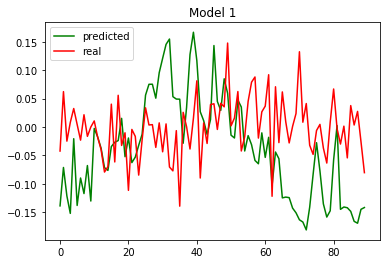

In [18]:
plt.plot(yhat, "g", label = "predicted")
plt.plot(yt, "r", label = "real")
plt.title("Model 1") 
plt.legend()
plt.savefig("test.png")
plt.show()

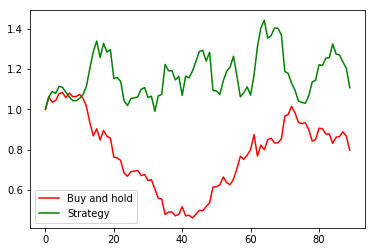

['rmse: 0.1073330034751382', 'mae: 0.088136464', (0.5109798162631058, 0.5056179775280899, 0.5059925093632959, None), 'strategy outperformance in %: 31.090473748308934', 'Sharpe ratio: 0.9174664621478757', 'Max drawdown in %: -28.638110820713113']


In [19]:
def error_performance(yhat, yt, plot = False):
    rmse_normalized = math.sqrt(mean_squared_error(yhat, yt))
    mae_normalized = mean_absolute_error(yhat, yt)
    excess_r, sharpe, drawdown = strategy_profit(yhat, yt, plot)

    error_performance = ["rmse: " + str(rmse_normalized), "mae: " + str(mae_normalized),
                             precision_recall_fscore_support(binary(yhat), binary(yt), average = 'weighted'),
                               "strategy outperformance in %: " + str(excess_r*100), "Sharpe ratio: " + str(sharpe),
                                 "Max drawdown in %: " + str(drawdown*100)]
    return error_performance

print(error_performance(yhat, yt, plot = True)[0:6])